# Introduction to bandit-mlx

A multi-armed bandit simulation library built with Apple's MLX framework.

This notebook covers the core building blocks:
1. Environments - Creating bandit problems
2. Algorithms - Three classic bandit algorithms
3. Simulation - Running experiments
4. Metrics - Analyzing results
5. Visualization - Creating plots

## Setup

Import the necessary libraries.

In [3]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import mlx.core as mx
from bandit_sim import (
    BanditEnvironment,
    EpsilonGreedy,
    UCB1,
    ThompsonSampling,
    BanditSimulation,
    SimulationConfig,
    compute_metrics,
    compare_algorithms,
    create_comparison_dashboard,
)
import matplotlib.pyplot as plt

print("All imports successful!")

All imports successful!


## Building Block 1: Bandit Environment

A bandit environment represents the problem - a set of "arms" (actions) with unknown reward distributions.

### Creating an Environment

Create a 5-armed bandit with Bernoulli rewards (like coin flips with different probabilities).

In [5]:
# Create a 5-armed bandit with different success probabilities
env = BanditEnvironment.from_parameters(
    bernoulli_probs=[0.1, 0.3, 0.5, 0.7, 0.2]
)

print(f"Number of arms: {env.num_arms}")
print(f"Distribution type: {env.distribution}")
print(f"Expected rewards: {env.expected_rewards()}")
print(f"\nBest arm: {mx.argmax(env.expected_rewards()).item()} (reward: {mx.max(env.expected_rewards()).item()})")

Number of arms: 5
Distribution type: bernoulli
Expected rewards: array([0.1, 0.3, 0.5, 0.7, 0.2], dtype=float32)

Best arm: 3 (reward: 0.699999988079071)


What does this mean?
- Arm 0: 10% success probability
- Arm 1: 30% success probability
- Arm 2: 50% success probability
- Arm 3: 70% success probability (Best arm)
- Arm 4: 20% success probability

Goal: Discover which arm is best by trying them out.

### Sampling from the Environment

Pull some arms to see what happens:

In [7]:
# Pull arm 3 (the best one) 10 times
chosen_arms = mx.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])  # All arm 3
rewards, _ = env.sample(mx.random.key(42), chosen_arms)

print(f"Pulled arm 3 ten times, got rewards: {rewards}")
print(f"Total reward: {mx.sum(rewards).item()}")
print(f"Success rate: {mx.mean(rewards).item():.1%} (expected: 70%)")

Pulled arm 3 ten times, got rewards: array([1, 1, 1, ..., 0, 1, 1], dtype=float32)
Total reward: 9.0
Success rate: 90.0% (expected: 70%)


## Building Block 2: Bandit Algorithms

Algorithms decide which arm to pull based on past experience. There are three algorithms in bandit-mlx.

### Algorithm 1: Epsilon-Greedy

Strategy: Most of the time, pick the best arm so far. But with probability epsilon, explore randomly.

In [8]:
epsilon_greedy = EpsilonGreedy(num_arms=5, epsilon=0.1)

print("Epsilon-Greedy Algorithm")
print(f"  - Number of arms: {epsilon_greedy.num_arms}")
print(f"  - Epsilon: 0.1 (10% exploration, 90% exploitation)")
print(f"  - Strategy: Explore randomly 10% of the time, exploit best arm 90% of the time")

Epsilon-Greedy Algorithm
  - Number of arms: 5
  - Epsilon: 0.1 (10% exploration, 90% exploitation)
  - Strategy: Explore randomly 10% of the time, exploit best arm 90% of the time


### Algorithm 2: UCB1 (Upper Confidence Bound)

Strategy: Pick the arm with the highest optimistic estimate. Arms with less data get a bonus (uncertainty bonus).

In [9]:
ucb1 = UCB1(num_arms=5, exploration_coef=2.0)

print("UCB1 Algorithm")
print(f"  - Number of arms: {ucb1.num_arms}")
print(f"  - Exploration coefficient: 2.0")
print(f"  - Strategy: Balance exploration vs exploitation using confidence bounds")

UCB1 Algorithm
  - Number of arms: 5
  - Exploration coefficient: 2.0
  - Strategy: Balance exploration vs exploitation using confidence bounds


### Algorithm 3: Thompson Sampling

Strategy: Maintain a probability distribution over each arm's reward. Sample from these distributions to make decisions.

In [10]:
thompson = ThompsonSampling(num_arms=5, alpha=1.0, beta=1.0)

print("Thompson Sampling Algorithm")
print(f"  - Number of arms: {thompson.num_arms}")
print(f"  - Prior: Beta(α=1.0, β=1.0) for each arm")
print(f"  - Strategy: Bayesian approach - sample from posterior distributions")

Thompson Sampling Algorithm
  - Number of arms: 5
  - Prior: Beta(α=1.0, β=1.0) for each arm
  - Strategy: Bayesian approach - sample from posterior distributions


---

## Building Block 3: Running Simulations

Now let's run a simulation! We'll use **Thompson Sampling** to learn which arm is best.

### Configure the Simulation

In [11]:
# Simulation configuration
config = SimulationConfig(
    horizon=500,   # Number of time steps (pulls)
    runs=50        # Number of independent simulations to run in parallel
)

print(f"Simulation Configuration:")
print(f"  - Horizon: {config.horizon} steps")
print(f"  - Runs: {config.runs} parallel simulations")
print(f"  - Total arm pulls: {config.horizon * config.runs:,}")

Simulation Configuration:
  - Horizon: 500 steps
  - Runs: 50 parallel simulations
  - Total arm pulls: 25,000


### Run the Simulation

In [12]:
# Create and run simulation
simulation = BanditSimulation(
    environment=env,
    algorithm=thompson,
    config=config
)

# Run with a random key for reproducibility
results = simulation.run(mx.random.key(42))

print("Simulation complete!")
print(f"\nResults shape:")
print(f"  - Cumulative rewards: {results.cumulative_rewards.shape}")
print(f"  - Cumulative regret: {results.cumulative_regret.shape}")
print(f"  - Arm selections: {results.arm_selections.shape}")

Simulation complete!

Results shape:
  - Cumulative rewards: (50, 500)
  - Cumulative regret: (50, 500)
  - Arm selections: (50, 500)


Understanding the results:
- Shape (50, 500) means 50 runs times 500 time steps
- Each run is an independent experiment
- MLX processes all 50 runs in parallel

### Quick Results Check

In [13]:
# Average final reward across all runs
avg_final_reward = float(mx.mean(results.cumulative_rewards[:, -1]))
avg_final_regret = float(mx.mean(results.cumulative_regret[:, -1]))

print(f"Average performance across {config.runs} runs:")
print(f"  - Final cumulative reward: {avg_final_reward:.1f}")
print(f"  - Final cumulative regret: {avg_final_regret:.1f}")
print(f"  - Average reward per pull: {avg_final_reward/config.horizon:.3f}")

Average performance across 50 runs:
  - Final cumulative reward: 332.0
  - Final cumulative regret: 17.9
  - Average reward per pull: 0.664


## Building Block 4: Computing Metrics

The compute_metrics() function aggregates results across multiple runs and computes statistics.

In [14]:
# Compute aggregated metrics
metrics = compute_metrics(results)

print("Aggregated Metrics:")
print(f"  - Mean cumulative reward: shape {metrics.mean_cumulative_reward.shape}")
print(f"  - Std cumulative reward: shape {metrics.std_cumulative_reward.shape}")
print(f"  - Mean cumulative regret: shape {metrics.mean_cumulative_regret.shape}")
print(f"  - Std cumulative regret: shape {metrics.std_cumulative_regret.shape}")
print(f"  - Arm selection frequencies: {metrics.arm_selection_frequencies}")

Aggregated Metrics:
  - Mean cumulative reward: shape (500,)
  - Std cumulative reward: shape (500,)
  - Mean cumulative regret: shape (500,)
  - Std cumulative regret: shape (500,)
  - Arm selection frequencies: array([0.01228, 0.0228, 0.05228, 0.89496, 0.01768], dtype=float32)


### Arm Selection Analysis

Which arms did Thompson Sampling choose?

In [16]:
print("Arm Selection Frequencies:\n")
for arm in range(5):
    freq = float(metrics.arm_selection_frequencies[arm])
    expected_reward = float(env.expected_rewards()[arm])
    marker = " (Best arm)" if arm == 3 else ""
    print(f"  Arm {arm}: {freq:6.1%} (expected reward: {expected_reward:.1f}){marker}")

Arm Selection Frequencies:

  Arm 0:   1.2% (expected reward: 0.1)
  Arm 1:   2.3% (expected reward: 0.3)
  Arm 2:   5.2% (expected reward: 0.5)
  Arm 3:  89.5% (expected reward: 0.7) (Best arm)
  Arm 4:   1.8% (expected reward: 0.2)


Did Thompson Sampling find the best arm (arm 3)?

## Building Block 5: Visualization

Visualize the learning process with a simple plot:

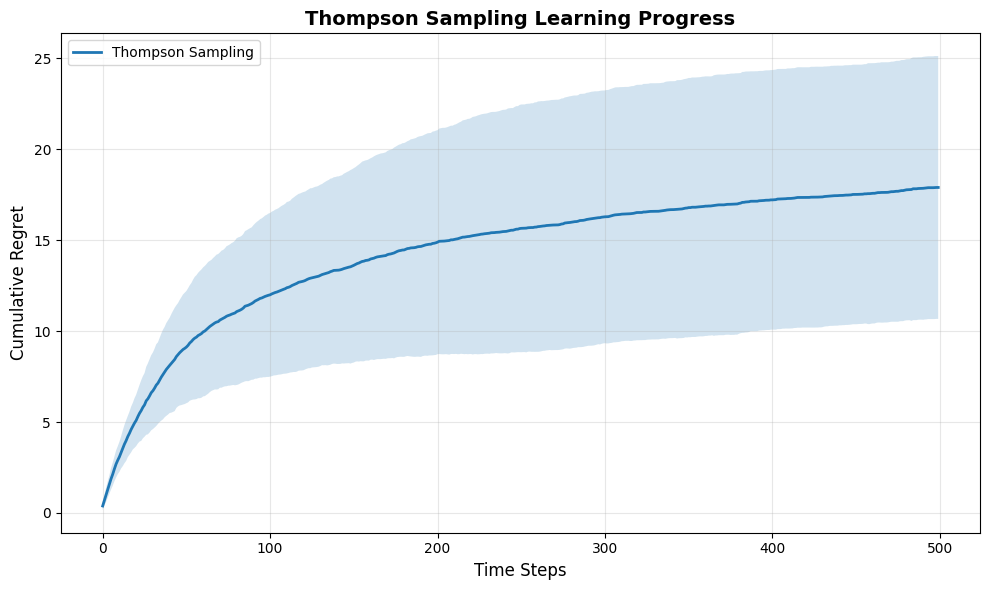

The plot shows how regret accumulates over time.
Lower is better. Notice how the curve flattens as the algorithm learns.


In [17]:
# Plot cumulative regret over time
plt.figure(figsize=(10, 6))

# Plot mean with confidence bands
time_steps = range(config.horizon)
mean_regret = metrics.mean_cumulative_regret
std_regret = metrics.std_cumulative_regret

plt.plot(time_steps, mean_regret, label='Thompson Sampling', linewidth=2)
plt.fill_between(
    time_steps,
    mean_regret - std_regret,
    mean_regret + std_regret,
    alpha=0.2
)

plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Regret', fontsize=12)
plt.title('Thompson Sampling Learning Progress', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("The plot shows how regret accumulates over time.")
print("Lower is better. Notice how the curve flattens as the algorithm learns.")

## Bonus: Comparing All Three Algorithms

Compare all three algorithms side by side.

In [32]:
# Run all three algorithms
print("Running all three algorithms...")

algorithms = {
    "Epsilon-Greedy (e=0.1)": EpsilonGreedy(num_arms=5, epsilon=0.1),
    "UCB1 (c=2.0)": UCB1(num_arms=5, exploration_coef=2.0),
    "Thompson Sampling": ThompsonSampling(num_arms=5, alpha=1.0, beta=1.0)
}

results_dict = {}
key = mx.random.key(42)

for name, algo in algorithms.items():
    print(f"  Running {name}...")
    sim = BanditSimulation(env, algo, config)
    key, subkey = mx.random.split(key)
    results_dict[name] = sim.run(subkey)
    print(f" Done.")


Running all three algorithms...
  Running Epsilon-Greedy (e=0.1)...
 Done.
  Running UCB1 (c=2.0)...
 Done.
  Running Thompson Sampling...
 Done.


In [22]:
# Compare algorithms
metrics_dict = compare_algorithms(results_dict)

print("Final Performance Comparison:\n")
for name, metrics in metrics_dict.items():
    final_reward = float(metrics.mean_cumulative_reward[-1])
    final_regret = float(metrics.mean_cumulative_regret[-1])
    print(f"{name:25s} | Reward: {final_reward:6.1f} | Regret: {final_regret:5.1f}")

Final Performance Comparison:

Epsilon-Greedy (e=0.1)    | Reward:  302.9 | Regret:  47.9
UCB1 (c=2.0)              | Reward:  293.4 | Regret:  55.9
Thompson Sampling         | Reward:  332.3 | Regret:  17.4


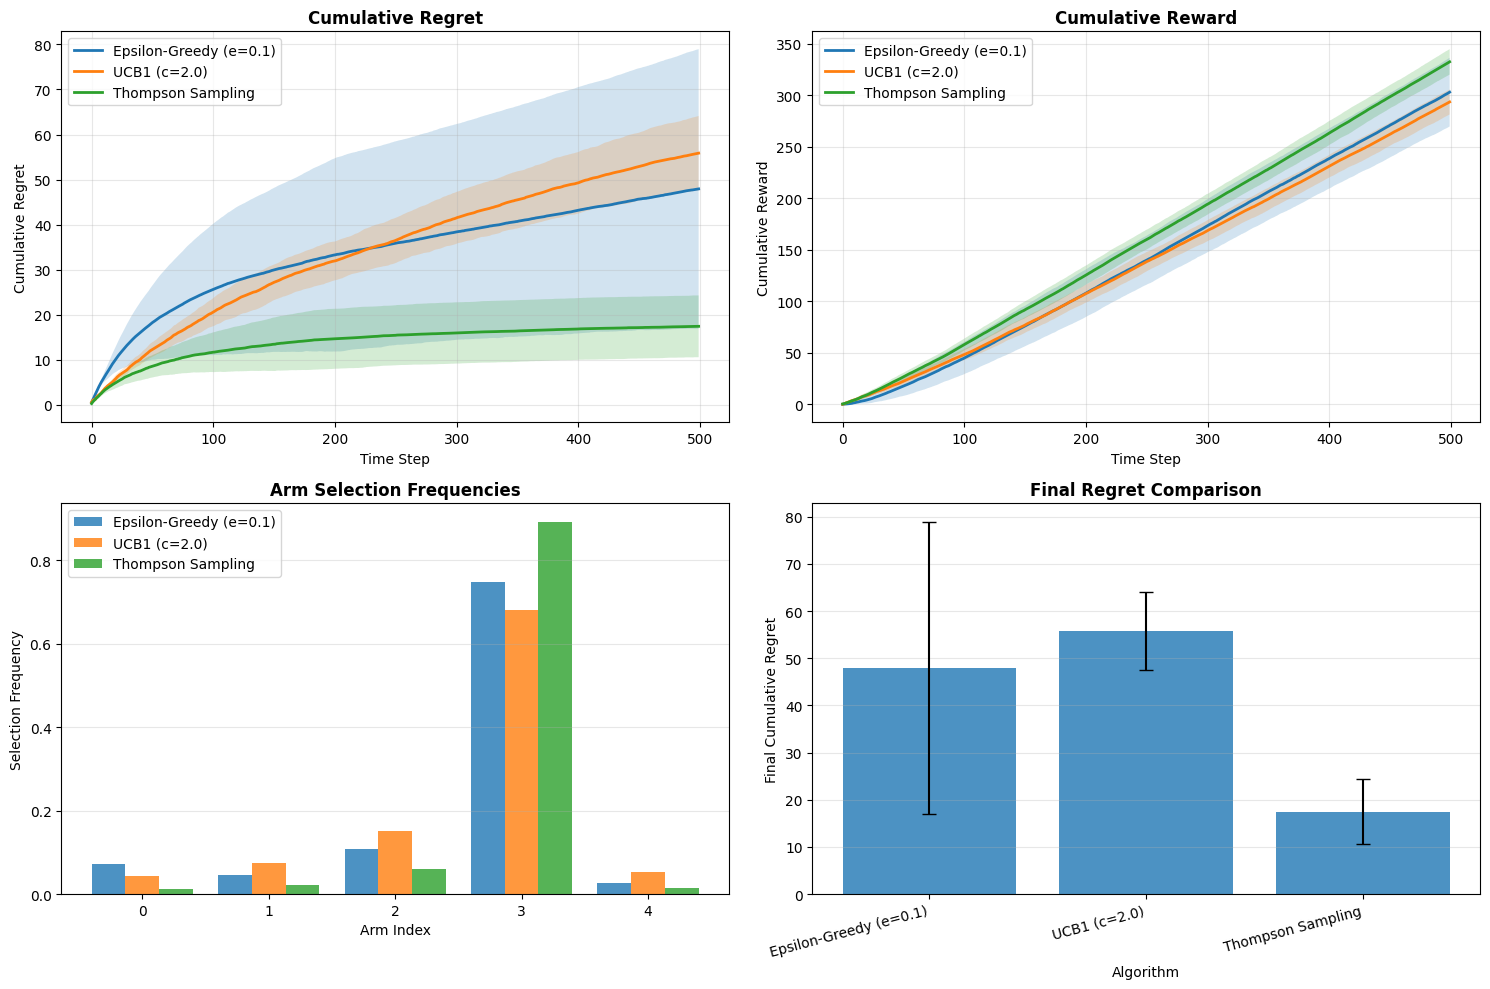


The dashboard shows:
  - Top-left: Cumulative regret (lower is better)
  - Top-right: Cumulative reward (higher is better)
  - Bottom-left: Which arms each algorithm chose
  - Bottom-right: True expected rewards (ground truth)


In [33]:
# Create comprehensive dashboard
fig = create_comparison_dashboard(
    metrics_dict,
    num_arms=5
)

plt.show()

print("\nThe dashboard shows:")
print("  - Top-left: Cumulative regret (lower is better)")
print("  - Top-right: Cumulative reward (higher is better)")
print("  - Bottom-left: Which arms each algorithm chose")
print("  - Bottom-right: True expected rewards (ground truth)")